# Predicting if a Player would be out for Certain Number of Days

In [1]:
## importing packages 
import pandas as pd ## data science essentials
import seaborn as sns ## enhanced data visualization essentials
import matplotlib.pyplot as plt ## data visualization essentials 
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score   

## loading dataset
pi = pd.read_csv ('InjuryRecord.csv')
pt = pd.read_csv ('PlayerTrackData.csv')
pl = pd.read_csv ('PlayList.csv')

pi.head(n=5)

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [2]:
## player track dataframe
pt.head(n=5)

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09


# Feature Engineering : Rate of Change
-----------------------------------------------------------
Acceleration is calulated by 
    rate of change in velocity / rate of change in change in time. We have to find velocity and its formula is
    rate of change in position / rate of change in time.

In [3]:
## velocity 
## position change for x = longtitudinal 
pt['p_chg_x'] = pt['x'].diff()

## change in time 
pt['t_chg'] = pt['time'].diff()

## velocity for x 
pt['vel_x'] = pt['p_chg_x'] / pt['t_chg']

In [4]:
## velocity 
## position change for y = lateral
pt['p_chg_y'] = pt['y'].diff()

## velocity for y 
pt['vel_y'] = pt['p_chg_y'] / pt['t_chg']

In [5]:
## acceleration for x
pt['acc_x'] = pt['vel_x'] / pt['t_chg']

## accleration for y
pt['acc_y'] = pt['vel_y'] / pt['t_chg']

In [6]:
## just checking 
pt.head()

,PlayKey,time,event,x,y,dir,dis,o,s,p_chg_x,t_chg,vel_x,p_chg_y,vel_y,acc_x,acc_y
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12,-0.01,0.1,-0.1,-0.01,-0.1,-1.0,-1.0
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12,-0.01,0.1,-0.1,0.00,0.0,-1.0,0.0
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10,0.00,0.1,0.0,0.00,0.0,0.0,0.0
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09,0.00,0.1,0.0,0.00,0.0,0.0,0.0


In [7]:
## play list dataframe
pl.head(n = 5)

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


In [8]:
## define function 
def create_motion_data_df(pi, pl, pt):
    '''
    Function to create aggregated values for motion data.
    '''
    # create a field with the angle between direction and orientation
    pt['angle'] = pt['o'] - pt['dir']
    
    # create grouped dataframes
    grouped_max = pt[['PlayKey','time', 'dir', 'dis', 'o', 's', 'angle', 'acc_x', 'acc_y']].groupby(by=['PlayKey']).max()
    grouped_average = pt[['PlayKey','time', 'dir', 'dis', 'o', 's', 'angle', 'acc_x', 'acc_y']].groupby(by=['PlayKey']).mean()
    
    # merge with play data
    pl = pl.merge(grouped_max.reset_index(), on = ['PlayKey'])
    pl = pl.merge(grouped_average.reset_index(), on = ['PlayKey'], suffixes=('_max', '_avg'))
    
    # merge with injury data
    pi = pi.drop(['PlayerKey', 'GameID'], axis = 1).merge(pl, on = ['PlayKey'], how = 'outer').dropna()#fillna(0)
   
    return pi

In [9]:
comb_org = create_motion_data_df(pi, pl, pt)

comb_org.head(n = 5)

,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,PlayerKey,GameID,RosterPosition,...,acc_x_max,acc_y_max,time_avg,dir_avg,dis_avg,o_avg,s_avg,angle_avg,acc_x_avg,acc_y_avg
0,39873-4-32,Knee,Synthetic,1.0,1.0,1.0,1.0,39873.0,39873-4,Linebacker,...,83.0,66.0,22.05,189.061222,0.160837,126.987421,1.489140,-62.073801,8.097255,5.407200
1,46074-7-26,Knee,Natural,1.0,1.0,0.0,0.0,46074.0,46074-7,Linebacker,...,71.0,24.0,11.10,144.081300,0.210269,146.973453,2.024215,2.892152,18.237922,0.453080
2,36557-1-70,Ankle,Synthetic,1.0,1.0,1.0,1.0,36557.0,36557-1,Safety,...,23.0,4.0,7.95,156.608562,0.168875,87.116313,1.574938,-69.492250,-6.074836,-12.150183
3,46646-3-30,Ankle,Natural,1.0,0.0,0.0,0.0,46646.0,46646-3,Linebacker,...,69.0,24.0,12.45,126.469440,0.237160,188.707200,2.194320,62.237760,17.807945,-2.788053
4,43532-5-69,Ankle,Synthetic,1.0,1.0,1.0,1.0,43532.0,43532-5,Wide Receiver,...,57.0,12.0,17.45,164.235943,0.087743,160.628057,0.760543,-3.607886,5.074294,0.614284


In [10]:
## creating copy for safety measures 
comb = comb_org.copy()


In [11]:
## dimensions of the dataset 

print (f""" 
Size of the Dataset
-------------------
No of Observations: {comb.shape[0]}
No of Features: {comb.shape[1]}
""")

 
Size of the Dataset
-------------------
No of Observations: 70
No of Features: 36



In [12]:
## dataset info 
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 104
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PlayKey         70 non-null     object 
 1   BodyPart        70 non-null     object 
 2   Surface         70 non-null     object 
 3   DM_M1           70 non-null     float64
 4   DM_M7           70 non-null     float64
 5   DM_M28          70 non-null     float64
 6   DM_M42          70 non-null     float64
 7   PlayerKey       70 non-null     float64
 8   GameID          70 non-null     object 
 9   RosterPosition  70 non-null     object 
 10  PlayerDay       70 non-null     float64
 11  PlayerGame      70 non-null     float64
 12  StadiumType     70 non-null     object 
 13  FieldType       70 non-null     object 
 14  Temperature     70 non-null     float64
 15  Weather         70 non-null     object 
 16  PlayType        70 non-null     object 
 17  PlayerGamePlay  70 non-null     floa

In [13]:
## checking for missing values 
comb.isnull().sum(axis = 0)

PlayKey           0
BodyPart          0
Surface           0
DM_M1             0
DM_M7             0
DM_M28            0
DM_M42            0
PlayerKey         0
GameID            0
RosterPosition    0
PlayerDay         0
PlayerGame        0
StadiumType       0
FieldType         0
Temperature       0
Weather           0
PlayType          0
PlayerGamePlay    0
Position          0
PositionGroup     0
time_max          0
dir_max           0
dis_max           0
o_max             0
s_max             0
angle_max         0
acc_x_max         0
acc_y_max         0
time_avg          0
dir_avg           0
dis_avg           0
o_avg             0
s_avg             0
angle_avg         0
acc_x_avg         0
acc_y_avg         0
dtype: int64

In [14]:
## number of injuries per body part 
comb['BodyPart'].value_counts()

Knee     34
Ankle    32
Foot      4
Name: BodyPart, dtype: int64

Presently,
percentage of players with knee injuries is 48.57142857142857% and
percentage of players with ankle injuries is 45.714285714285715% and
percentage of players with foot injuries is 5.714285714285714% and


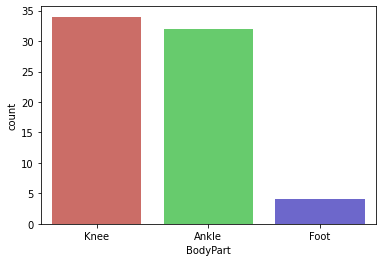

In [15]:
## percentages of each injury with regard to total injuries 
## _in = injuries 

knee_in  = len(comb[comb['BodyPart']== 'Knee'])

ankle_in = len(comb[comb['BodyPart']== 'Ankle'])

foot_in = len(comb[comb['BodyPart']== 'Foot'])



pct_of_knee_in = knee_in/(knee_in + ankle_in + foot_in)
print('Presently,')
print(f"""percentage of players with knee injuries is {pct_of_knee_in*100}% and""")

pct_of_ankle_in = ankle_in/(knee_in + ankle_in + foot_in)
print(f"""percentage of players with ankle injuries is {pct_of_ankle_in*100}% and""")

pct_of_foot_in = foot_in/(knee_in + ankle_in + foot_in)
print(f"""percentage of players with foot injuries is {pct_of_foot_in*100}% and""")


# Visualization
sns.countplot(x='BodyPart', data = comb, palette = 'hls')
plt.show()


# Features we Would have Wanted to Create our Model

We need to know the activities done during training before these injuries. These activities could make our predictive model work effectively or at all:
1. distance covered 
2. heart rate
3. acceleration and deceleration
4. sprints
5. stress load 
6. Previous injuries 
7. recovery time etc. 

We can get this data from popular sports analytics company statssports. They have all these variables in place with their own standard of measurement. All these data are collected from their sensor vests players use during training .
After this data is collected, we can use it to understand players breaking point i.e how much their body can take before an injury. 

# Machine Learning
----------------------------------------

We have decided to use the logistic regression because of the nature of our response variables, which are DM_M7, DM_M28 and DM_M42. In plain english, we are trying to predict (yes/no) if an injured player is going to be out for a certain time. 

Explaination Of Injury Record Data:

DM_M1: One hot encoding, indicates 1 or more days missed due to injury

DM_M7: One hot encoding, indicates 7 or more days missed due to injury

DM_M28: One hot encoding, indicates 28 or more days missed due to injury

DM_M42: One hot encoding, indicates 42 or more days missed due to injury

We dropped the DM_M1 column because once the player injured, he really cannot recover in one day especially injuries on the body parts metioned earlier. Also, it wouldn't help our model.   

One of the challenges we faced in building the model for machine learning is identifying when injuries occured; was it during the game or during the game week? and if the injury was a recurring one. We understand the potential for sudden injuries and injuries that come from accumulated stress. 

So, to account for both injury types, we used this steps: 
1. aggregated the movement metric in the player track data dataframe, recording the maximum, average and cummulated values.

2. merged the injury data with the play list data and player track data to other characteristics like stadium type, field type, weather etc. 

In [19]:
## removing DM_M1 column
comb = comb.drop(['DM_M1'], axis = 1)

# Feature Engineering
----------------------------------------

## Encoding Categorical Data 

In [20]:
# one hot encode for surface
one_hot_surface = pd.get_dummies(comb['Surface'],
              prefix = 'e')
# one hot encode for Body Part 
one_hot_body_part = pd.get_dummies(comb['BodyPart'],
                               prefix = 'e')

# one hot encoding Play Type
one_hot_play_type = pd.get_dummies(comb['PlayType'],
                                 prefix = 'e')


# dropping Surface column from dataframe and keeping encoded one 
comb = comb.drop(['Surface'], axis = 1)
# dropping Body Part column from dataframe and keeping encoded one 
comb = comb.drop(['BodyPart'], axis = 1)
# dropping Play Type column from the dataframe and keeping the encoded one 
comb = comb.drop(['PlayType'], axis = 1)

# adding encoded columns to dataset
comb = comb.join([one_hot_surface, one_hot_body_part, one_hot_play_type])


Dropping unnecessary columns 


In [21]:
comb = comb.drop(['PlayKey', 'PlayerKey',
                      'GameID', 'RosterPosition', 'PlayerDay', 'FieldType',
                      'PlayerGame', 'StadiumType', 'PlayerGamePlay', 
                       'Position','PositionGroup','dir_max',
                 'o_max', 'angle_max', 'dir_avg', 'o_avg', 'angle_avg', 'Weather'], axis = 1)

# Correlation Analysis

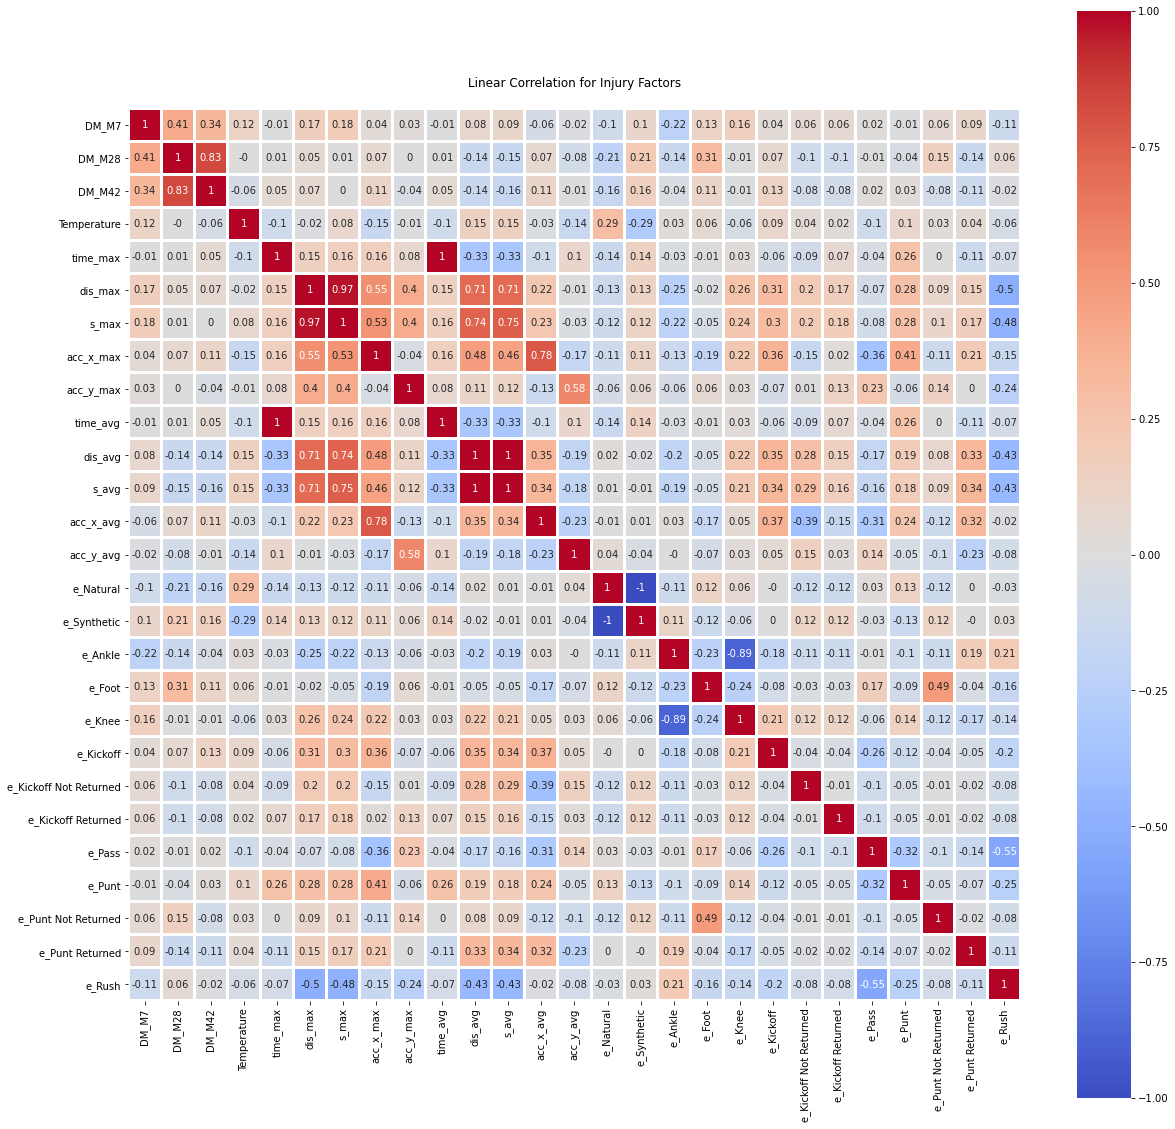

In [22]:
# converting correlation matrix into a DataFrame
df_corr = comb.corr(method = 'pearson').round(decimals= 2)

# specifying plot size (making it bigger)
fig, ax = plt.subplots(figsize=(20,20))


# developing a heatmap
sns.heatmap(data       = df_corr, # the correlation matrix
            cmap       = 'coolwarm',     #color of map
            square     = True,          # tightening the layout
            annot      = True,          # should there be numbers in the heatmap
            linecolor  = 'white',       # lines between boxes
            linewidths = 2)          # how thick should the lines be?


# title and displaying the plot
plt.title("""
Linear Correlation for Injury Factors
""")

plt.show()

# Logistic Regression in scikit-learn
------------------------------------

In [81]:
## preparing the explanatory and response variables
## declaring explanatory variable
comb_data = comb.drop(['DM_M7', 'DM_M28', 'DM_M42', 'time_max',
                      'dis_max', 's_max', 'acc_x_max', 'acc_y_max'], axis = 1)


## declaring response variable 
comb_response = comb.loc[:, 'DM_M7']

In [82]:
## train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            comb_data,
            comb_response,
            test_size    = 0.25,
            random_state = 219,
            stratify     = comb_response)


# merging training data for statsmodels
comb_train = pd.concat([x_train, y_train], axis = 1)

In [83]:
## just checking proportions 
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")





Response Variable Proportions (Training Set)
--------------------------------------------
1.0    0.79
0.0    0.21
Name: DM_M7, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1.0    0.78
0.0    0.22
Name: DM_M7, dtype: float64



In [84]:
# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)
# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)

LogReg Training ACCURACY: 0.7885
LogReg Testing  ACCURACY: 0.7778
LogReg Train-Test Gap   : 0.0107


C:\Users\Dennis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Confusion Matrix 
--------------------------

 The confusion matrix is a metric used to evaluate the performance of a classification model.

In [85]:
# creating a confusion matrix
print(confusion_matrix(y_true = y_test,
                       y_pred = logreg_pred))

[[ 0  4]
 [ 0 14]]


In [86]:
# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")


True Negatives : 0
False Positives: 4
False Negatives: 0
True Positives : 14



Our model performed well when prediting correctly the injured players which is a postive sign for our model.

# Area Under the Curve (AUC)
-----------------------------------------------

The area under the curve is another important metric in evaluating the performance of a classification model. 

This metric takes into account two key factors:

<u>Sensitivity</u><br>
Number of times the model predicted that an event WOULD occur over the number of times the event DID occur.

<u>Specificity</u><br>
Number of times the model predicted that an event WOULD NOT occur over the number of times the event DID NOT occur.
    

In [87]:
# area under the roc curve (auc)
print(f"""The Model Score is: {roc_auc_score(y_true  = y_test,
                    y_score = logreg_pred).round(decimals = 4)}""")

The Model Score is: 0.5


The AUC score is low and it affects the realibilty of our model esoecially for the DM_M28, DM_M42 response variables. We would consider creating better features that have high correlation with these injury lengths.

### Model Coefficients 

In [88]:
# zipping each feature name to its coefficient
logreg_model_values = zip(comb_data.columns,
                          logreg_fit.coef_.ravel().round(decimals = 2))


# setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)
    

# checking the results
for pair in logreg_model_lst:
    print(pair)

('intercept', 0.9)
('Temperature', 0.0)
('time_avg', 0.01)
('dis_avg', 0.01)
('s_avg', 0.08)
('acc_x_avg', -0.02)
('acc_y_avg', 0.02)
('e_Natural', -0.0)
('e_Synthetic', 0.48)
('e_Ankle', -0.57)
('e_Foot', 0.35)
('e_Knee', 0.7)
('e_Kickoff', -0.12)
('e_Kickoff Not Returned', 0.04)
('e_Kickoff Returned', 0.06)
('e_Pass', 0.36)
('e_Punt', -0.21)
('e_Punt Not Returned', 0.0)
('e_Punt Returned', 0.36)
('e_Rush', -0.01)


In [90]:
## This code may have to be run more than once ##

# dropping coefficients that are equal to zero

# printing out each feature-coefficient pair one by one
for feature, coefficient in logreg_model_lst:
        
        if coefficient == 0:
            logreg_model_lst.remove((feature, coefficient))

            
# checking the results
for pair in logreg_model_lst:
    print(pair)

('intercept', 0.9)
('time_avg', 0.01)
('dis_avg', 0.01)
('s_avg', 0.08)
('acc_x_avg', -0.02)
('acc_y_avg', 0.02)
('e_Synthetic', 0.48)
('e_Ankle', -0.57)
('e_Foot', 0.35)
('e_Knee', 0.7)
('e_Kickoff', -0.12)
('e_Kickoff Not Returned', 0.04)
('e_Kickoff Returned', 0.06)
('e_Pass', 0.36)
('e_Punt', -0.21)
('e_Punt Returned', 0.36)
('e_Rush', -0.01)
